In [1]:
import pandas as pd
import networkx as nx
import glob
import io
import re
import nltk

from nltk import word_tokenize
import string
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import operator
from wordcloud import WordCloud

# Part 2 - What do republican and democratic members tweet about?

**TF-IDF of the republican and democratic tweets.**

We will create two documents, one containing the words extracted from tweets of republican members, and the other for Democratic members. We will then use TF-IDF to compare the content of these two documents and create a word-cloud.

In [2]:
# Read user's handles
df = pd.read_csv('./tweet_names.csv', encoding ='utf-8')

In [3]:
# Our two main documents
unprocessed_dem_tweet_doc = []
unprocessed_rep_tweet_doc = []

path = './tweets_2019/*'

for filename in glob.glob(path):
    m = filename[14:]
    party_name = df.loc[df['WikiPageName']==m]['Party'].item()

    data = io.open('./tweets_2019/'+ m,'r', encoding="utf8", errors='ignore').read()     
    
    # Removing '&'
    data = data.replace("&amp;", '')
    
    # Removing retweets
    for rt in re.findall(r"RT @\w*:.*\n", data):
        data = data.replace(rt, '')
    
    # Removing links forwarding to original tweets or external sources
    for url in re.findall(r"\bhttps://t\.co/\w+\b", data):
        data = data.replace(url, '')
    
    # Each file is then appended to the rest of the concerned congressman's party's list
    if party_name == 'Republican':
        unprocessed_rep_tweet_doc += word_tokenize(data)
    else:
        unprocessed_dem_tweet_doc += word_tokenize(data)

For every twitter handle given in the CSV file, we open the corresponding file containing the congressman's tweets.
**To prevent unwanted results, we remove the "&amp" string from every file**, it's an HTML character reference meaning *&* and therefor not a word. 

To only keep congressmen's tweets and not their retweets, we then sort them out using a regular expression.

**⚠ CAUTION** : This approach is not 100% accurate because we only delete the tweet until we reach the end of the line. Because of that, some tweet containing line breaks might not be completly deleted.

To avoid complications down the line, we remove links associated to tweets as well. Otherwise, those links might be processed and invalidate our results.

In [4]:
dem_tweet_doc = []
rep_tweet_doc = []

for item, handle in df["tw_name"].items():
    rep_tweet_doc = list(filter(lambda a: a != handle, unprocessed_rep_tweet_doc))
    dem_tweet_doc = list(filter(lambda a: a != handle, unprocessed_dem_tweet_doc))

We then remove every other congressmen's handles from each list.

In [5]:
rep_tweet_doc = [item for item in rep_tweet_doc if item.isalpha()]
dem_tweet_doc = [item for item in dem_tweet_doc if item.isalpha()]

To remove punctuation, symbols and numbers, we only week letters.

In [6]:
stopwords = nltk.corpus.stopwords.words('english')

rep_tweet_doc = [item for item in rep_tweet_doc if item.lower() not in stopwords]
dem_tweet_doc = [item for item in dem_tweet_doc if item.lower() not in stopwords]

We then remove english stop-words from each list.

In [7]:
rep_tweet_doc = [item.lower() for item in rep_tweet_doc]
dem_tweet_doc = [item.lower() for item in dem_tweet_doc]

Finally, every letter is switch to lower case, in order to have homogeneous data.

### Compute the TF-IDF for each document

To compute the TF-IDF of each document, we need to first compute their TF and then each IDF.
We wrote a function to compute the Term Frequency in a more elegant and readable way.

In [8]:
def tf_calculator(l):
    tf = {}
    
    for item in l:
        if item in tf:
            tf[item] += 1
        else:
            tf[item] = 1
    
    return tf

In [9]:
# Compute every TF for each tweet document

rep_tweet_tf = tf_calculator(rep_tweet_doc)
dem_tweet_tf = tf_calculator(dem_tweet_doc)

Now that every TF has been calculated, we can move toward our Inverse Document Frequency (IDF).

**Because we only have two documents for this example, each word's IDF is either 1 or 2.**

In [10]:
idf = dict()

for word in set(rep_tweet_doc):
    idf[word] = 1

for word in set(dem_tweet_doc):
    if word in idf:
        idf[word] += 1
    else:
        idf[word] = 1

In [11]:
rep_tweet_tfidf = dict()
dem_tweet_tfidf = dict()

for word in rep_tweet_tf:
    rep_tweet_tfidf[word] = rep_tweet_tf[word] * idf[word]

for word in dem_tweet_tf:
    dem_tweet_tfidf[word] = dem_tweet_tf[word] * idf[word]

Now that we have both the TF and IDF for each word of each party, we can multiply them to get the final TF-IDF value of each word from each party.

(-0.5, 556.5, 557.5, -0.5)

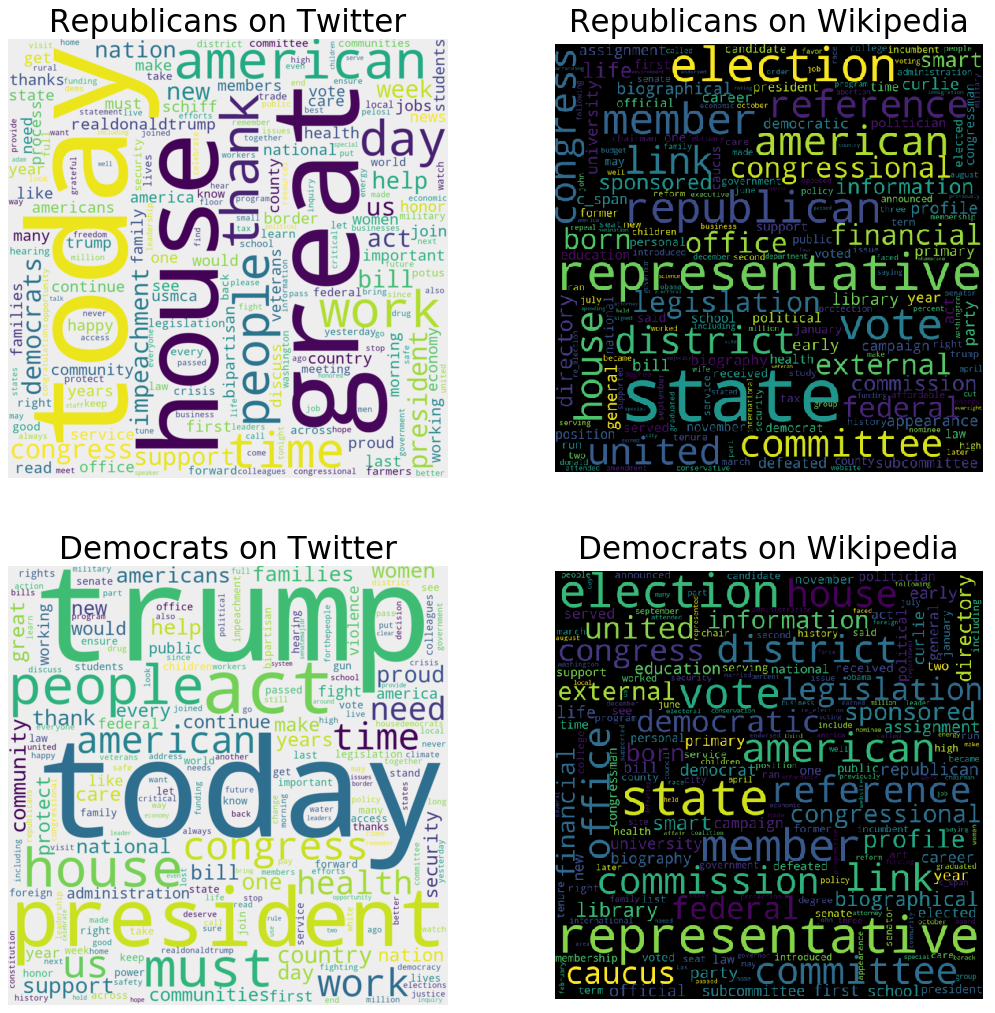

In [12]:
wordcloud_rep = WordCloud(width=1000, height=1000, background_color="#EEEEEE").generate_from_frequencies(rep_tweet_tfidf)
wordcloud_dem = WordCloud(width=1000, height=1000, background_color="#EEEEEE").generate_from_frequencies(dem_tweet_tfidf)

fig = plt.figure(figsize=(16, 16), dpi=80)

rep_tweet_plot = fig.add_subplot(2, 2, 1)
rep_tweet_plot.title.set_text("Republicans on Twitter")
rep_tweet_plot.title.set_size(28)
rep_tweet_plot.imshow(wordcloud_rep, interpolation="bilinear")
rep_tweet_plot.axis("off")

img = mpimg.imread("cloud_wiki_rep.png")
rep_wiki_plot = fig.add_subplot(2, 2, 2)
rep_wiki_plot.title.set_text("Republicans on Wikipedia")
rep_wiki_plot.title.set_size(28)
rep_wiki_plot.imshow(img)
rep_wiki_plot.axis("off")

dem_plot = fig.add_subplot(2, 2, 3)
dem_plot.title.set_text("Democrats on Twitter")
dem_plot.title.set_size(28)
dem_plot.imshow(wordcloud_dem, interpolation="bilinear")
dem_plot.axis("off")

img = mpimg.imread("cloud_wiki_dem.png")
dem_wiki_plot = fig.add_subplot(2, 2, 4)
dem_wiki_plot.title.set_text("Democrats on Wikipedia")
dem_wiki_plot.title.set_size(28)
dem_wiki_plot.imshow(img)
dem_wiki_plot.axis("off")

As we can see with the comparison side by side presented above, the most used words on twitter are completly different that what we found on Wikipedia.
In fact, twitter most used words are very different between Democrat and Republican representatives, therefor not boring at all.

We can see that both parties use a lot the word "today", probably to highlight present good actions taken by their party/in relation to their politic carrier.
On the Wikipedia page, the two parties have almost the same words in equal quantity, something predictable. Their pages describre their careers so they use almost the same lexical field.

Regarding the twitter side, we found a more subjective type of lexical field. For example, we see that the Democrats use a lot the word "Trump", it could be because they have a tendency to call him out on everything he does. To this we could say that Republicans could praise his actions but in those cases, Repulicans would more often quote him using his handlebar, which we removed from the word list. (See next code snippet for more infos about that)

In [21]:
print("Number of mentions from Democrats :\t{}\nNumber of mentions from Republicans :\t{}".format(unprocessed_dem_tweet_doc.count('realdonaldtrump'), unprocessed_rep_tweet_doc.count('realdonaldtrump')))

Number of mentions from Democrats :	27
Number of mentions from Republicans :	73
